# Using NMF to store data and denoise CryptoPunks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pip install opencv-python
import cv2
import os
import time

Note: you may need to restart the kernel to use updated packages.


In this day and age, the amount of stored data in the world is ever increasing, while the amount of resources and capacity to make digital storage is limited. With the rise of machine learning and data storage algorithms, there are a number of ways to optimize the data storage so one can represent the data with significantly less bits than the original. For instance there are several lossy compression methods to process images, where the file type JPEG is one of the most popular. A technique used in the storing of a JPEG is to group up similar looking pixels and representing them with the same color. Using this you will never be able to recover the original value of the pixels, but it is often good enough to fool the average human. A method to reduce the amount of stored data is Non-Negative Matrix Factorization (NMF) which reduces the dimensionality of a matrix while still storing useful and relevant information. When applying this technique one will recieve a $d \times m$ matrix and a $n \times d$ matrix from a $m \times n$ matrix. Here $d$ can be significantly smaller than both $m$ and $n$. This is not a lossless storing technique, because we will only get an approximate reconstruction of the original matrix. Other dimensionality reduction methods include Principle Component Analysis, which is a method where you represent the data with so-called principle components. These are eigenvectors of the covariance matrix for the data. These are both unsupervised learning techniques, which means that you don't set an output variable before training the machine. In contrast you have supervised learning with methods like regression, where you know what output you want to analyze. In this project we are going to apply the NMF method on $24 \times 24$ pixel images of faces, and study what features are saved in the reduced matrices and on what level reconstruction of the faces after the dimensionality reduction is possible. Here an unsupervised learning method is the easier approach since the algorithm will decide for us what to look for and categorize the image features.

## The NMF algorithm

The algorithm we are going to implement is Lee and Seung's multiplicative rule, which is a popular method due to it being simple and elegant. We start by defining our original matrix of data as $A$. We can approximate $A$ by writing it as a product of two different matrices $W$ and $H$. As described earlier $A$ is a $m \times n$ matrix, $W$ is a $m \times d$ matrix and $H$ is a $d \times n$ matrix. Here we can choose an arbitrary $d$ and we will later discuss the impact of different sizes of $d$. 

The algorithm made by Lee and Seung is an iterative numerical algorithm. For each iteration of the algorithm we update both the $H$ and $W$ matrix with the following update rule:
$$ H_{k+1} \gets H_k \odot (W^T_kA) \oslash (W^T_kW_kH_k) \\
W_{k+1} \gets W_k \odot (AH^T_{k+1}) \oslash (W_KH_{k+1}H^T_{k+1})$$

Here $\odot$ and $\oslash$ are element-wise multiplication and division respectively. For simplicitys sake we just set a maximum number of iterations to know when to stop, instead of setting a convergence criteria. We initialize $W$ and $H$ as matrices containing only positive elements, which is crucial for the algorithm to work properly as we will demonstrate later. This ensures that each update of $W$ and $H$ yields only positive elements. The $\delta$-value is there to make sure we never divide by zero.

We will be interested in looking at $\lVert A - WH \rVert_F$ to analyze our new matrices. One way to look at this expression is how much our new approximate matrix $WH = A_{NMF}$ deviates from our original $A$. From theory we know this expression converges to a local minimizer as the multiplicative update rule will satisfy: 
$$ \lVert A - W_{k+1}H_{k+1} \rVert_F \leq \lVert A-W_kH_k \rVert_F$$

The Lee and Seung's multiplicative update rule for NMF uses the hadamard product $\odot$ and hadamard division $\oslash$. From theory section 2.4 we know that this can be broken down into the componentwise update rule 
$$
(H_{k+1})_{ij} \gets (H_k)_{ij} \cdot \frac{(W_k^{T}A)_{ij}}{(W_k^TW_kH_k)_{ij}},
$$


$$
(W_{k+1})_{ij} \gets (W_k)_{ij} \cdot \frac{(AH^T_{k+1})_{ij}}{(W_kH_{k+1}H^T_{k+1})_{ij}}, $$
where $(A)_{ij}$ denotes the element in row i and column j of the matrix A. If the matrices $W$ and $H$ are initialized as positivie and $A$ is assumed non-negative, it is immediately obvious from the componentwise update rule that every iteration has to yield a positive result for $W$ and $H$.  

When $W$ and $H$ satisfies $WH = A$ we want the algorithm to stop updating the values for $W$ and $H$, in other words keep $H_{k+1} = H_k$ for every iteration. This is ensured by the fact that if $(W_k^TA) \oslash (W_k^TW_kH_k)$ is matrix of ones, we see from the elementwise update above that this results in 
$$
(H_{k+1})_{ij} \gets (H_k)_{ij} \cdot \frac{(W_k^{T}A)_{ij}}{(W_k^TW_kH_k)_{ij}} \implies (H_{k+1})_{ij} \gets (H_k)_{ij} \cdot 1 
$$
We therefore conclude
$$
H_{k+1} = H_k$$
This always happens when $WH = A$, this is immediately obvious when we insert it in the update rule 
$$(W_k^TA) \oslash (W_k^TW_kH_k) = (W_k^TW_kH_k) \oslash (W_k^TW_kH_k) 
= 1$$

If the initial matrices $H_0$ and $W_0$ are matrices containing only zeros the algorithm will never make an update or change the value for any iteration $H_k$, $W_k$ since every step involves taking the hadamard products 
$ H_k \odot (W_k^T A) \oslash (W_k^T W_k H_k)$, 
$ W_k \odot AH_{k+1}^T \oslash (W_k^TH_{k+1}H^T_{k+1})$ 
and  This will always just be a new matrix containing only zeros. Since the elementwise product of a matrix containing only elements equal to zero yields a matrix containing only zeros. As explained above we always add a $\delta$ to ensure that we never divide by zero. 

In [2]:
# Implementation of the algorithm.
def NMF(V, d, delta = 1e-9, maxiter = 1000, seed = 0):
    """
    We initialize W and H as positive and scale them. Then for each iteration we update W and H using the multiplicative update rule. We store the deviation from the original V
    input:
        V: (m,n) input array
        d: integer, Number of components we want to decompose V into
        delta: float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
        V_dev: (maxiter) array
    """
    if seed != 0:
        np.random.seed(seed)
    W = np.random.uniform(0,1,(V.shape[0],d))
    H = np.random.uniform(0,1,(d,V.shape[1]))
    W = np.sqrt(np.mean(V)/d)*W
    H = np.sqrt(np.mean(V)/d)*H
    V_dev = np.zeros(maxiter+1)
    for k in range(maxiter):
        V_dev[k] = np.linalg.norm(V-np.dot(W,H)) # The Frobenius norm is the standard norm for matrices
        H = H*np.dot(W.T,V)/(np.dot(W.T,np.dot(W,H))+delta) # Dot product is associative
        W = W*np.dot(V,H.T)/(np.dot(W,np.dot(H,H.T))+delta)
    V_dev[-1] = np.linalg.norm(V-np.dot(W,H))
    return W, H, V_dev

To investigate the properties of the NMF algorithm we will define and use these four matrices:
$$ A_1 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}, A_2 = \begin{bmatrix} 1 & 2 \\ 1 & 1 \\ 1 & 2 \end{bmatrix}, A_3 = \begin{bmatrix} 2 & 1 & 1 \\ 2 & 1 & 1 \\ 1 & 1 & 2 \end{bmatrix}, A_4 = \begin{bmatrix} 2 & 1 & 0 \\ 1 & 2 & 3 \\ 0 & 3 & 3 \end{bmatrix} $$

In [4]:
A1 = np.identity(2)
A2 = np.array([[1,2],[1,1],[1,2]])
W1337, H1337, V_dev1337 = NMF(A1,1, seed=1337)
W13372, H13372, V_dev13372 = NMF(A2,1, seed=1337)

W420, H420, V_dev420 = NMF(A1,1,seed=420)
W4202, H4202, V_dev4202 = NMF(A2,1,seed=420)

# print(W1337,H1337,np.dot(W1337,H1337),V_dev1337[-1])
# print("----------------------")
# print(W13372,H13372,np.dot(W13372,H13372),V_dev13372[-1])
# print("----------------------")
# print(W420,H420,np.dot(W420,H420),V_dev420[-1])
# print("----------------------")
# print(W4202,H4202,np.dot(W4202,H4202),V_dev4202[-1])

Here we apply NMF on both $A_1$ and $A_2$ with $d=1$ and look at the reduced matrices $W$ and $H$, the reconstructed approximation $WH$ and the expression $\lVert A-WH \rVert_F$. Since we initialize $W$ and $H$ as matrices with random elements, we set the random seed with `np.random.seed()` so we can get consistent results for inspecting and comparing values.

With `np.random.seed()` set to $1337$:
| Matrix | $W$ | $H$ | $WH$ | $ \lVert A - WH \rVert_F$ |
| --- | --- | --- | --- | --- |
| $A_1$ | $\begin{bmatrix} 0.18528 \\ 0.11221 \end{bmatrix}$ | $\begin{bmatrix} 3.94892 & 2.39148 \end{bmatrix}$ | $\begin{bmatrix} 0.73166 & 0.44310 \\ 0.44310 & 0.26834 \end{bmatrix}$ | 1 |
| $A_2$ | $\begin{bmatrix} 0.31032 \\ 0.18940 \\ 0.31032 \end{bmatrix}$ | $\begin{bmatrix} 3.54549 & 6.26201 \end{bmatrix}$ | $\begin{bmatrix} 1.10025 & 1.94324 \\ 0.67150 & 1.18599 \\ 1.10025 & 1.94324 \end{bmatrix}$ | 0.41115 |

With `np.random.seed()` set to $420$:
| Matrix | $W$ | $H$ | $WH$ | $ \lVert A - WH \rVert_F$ |
| --- | --- | --- | --- | --- |
| $A_1$ | $\begin{bmatrix} 0.22320 \\ 0.32034 \end{bmatrix}$ | $\begin{bmatrix} 1.46420 & 2.10149 \end{bmatrix}$ | $\begin{bmatrix} 0.32680 & 0.46904 \\ 0.46904 & 0.67320 \end{bmatrix}$ | 1 |
| $A_2$ | $\begin{bmatrix} 0.50410 \\ 0.30766 \\ 0.50410 \end{bmatrix}$ | $\begin{bmatrix} 2.18257 & 3.85484 \end{bmatrix}$ | $\begin{bmatrix} 1.10025 & 1.94324 \\ 0.67150 & 1.18599 \\ 1.10025 & 1.94324 \end{bmatrix}$ | 0.41115 |

We immediately notice that $\lVert A-WH \rVert_F$ is the same for two different random seeds. This indicates that the algorithm has converged to a minima and since we get the same result twice it might be a global minima. Even though we get the same deviation from the original matrix with both seeds, we observe a different $WH$ for $A_1$ with different seeds and $W$ and $H$ is not alike for neither $A_1$ nor $A_2$. This implies that there are a lot of different solutions from the NMF that will converge to the same approximate matrix. 

It can be shown that $\lVert A_1 - W_kH_k \rVert _F = 1$ for every iteration after the first iteration.

Assume $W_0 = \dbinom{a}{b}$, $H_0 = \begin{pmatrix} c&d \end{pmatrix} \newline $ Using the multiplicative rule we obtain $H_1 = H_0 \odot (W_0^TA) \oslash (W_0^TW_0H_0) = \begin{pmatrix} \frac{a}{a^2+b^2} &\frac{b}{a^2+b^2} \end {pmatrix} $ after some algebraic multiplication.

And we get: $$W_1 = W_0 \odot AH_{1}^T \oslash (W_0^TH_{1}H^T_{1}) = \dbinom{a}{b}$$

This means that $W_1 = W_0 \implies W_k = W_0$. Note also that $H_1$ is only dependent on the initialization of $W_0$, and therefore, since $W_k$ always has the same value, $H_k = H_1$. With this newfound knowledge we can show that the frobenius norm of $A-W_kW_k = 1$ after atleast one iteration. 

$$W_kH_k = \dbinom{a}{b}\begin{pmatrix} \frac{a}{a^2+b^2} &\frac{b}{a^2+b^2} \end {pmatrix}  = \begin{pmatrix} \frac{a^2}{a^2+b^2} && \frac{ab}{a^2+b^2} \\ \frac{ab}{a^2+b^2} && \frac{b^2} {a^2+b^2}\end {pmatrix} \newline$$
$$\lVert A_1 - W_kH_k \rVert _F = \bigg\lVert \begin{matrix} 1 - \frac{a^2}{a^2+b^2} && -\frac{ab}{a^2+b^2} \\ -\frac{ab}{a^2+b^2} && 1 - \frac{b^2} {a^2+b^2}\end {matrix} \bigg\rVert _F = \bigg\lVert \begin{matrix} \frac{b^2}{a^2+b^2} && -\frac{ab}{a^2+b^2} \\ -\frac{ab}{a^2+b^2} && \frac{a^2} {a^2+b^2}\end {matrix} \bigg\rVert _F = \frac{1}{a^2+b^2}\sqrt{a^4+2a^2b^2+b^4} = \frac{1}{a^2+b^2} \cdot (a^2+b^2) = 1$$

We therefore conclude that $\lVert A_1 - W_kH_k \rVert _F = 1$ for all initialisations after one iteration. 

In [3]:
A3 = np.array([[2,1,1],[2,1,1],[1,1,2]])
A4 = np.array([[2,1,0],[1,2,3],[0,3,3]])

print(f"Matrix rank for A3: {np.linalg.matrix_rank(A3)}\nMatrix rank for A4: {np.linalg.matrix_rank(A4)}")

Matrix rank for A3: 2
Matrix rank for A4: 3


We will now investigate the impact of different values of $d$ on matrices $A_3$ and $A_4$. The ranks of these matrices will be of interest and looking at the ranks of $A_3$ and $A_4$ we can see that the rank of $A_3$ is 2 and the rank of $A_4$ is 3.

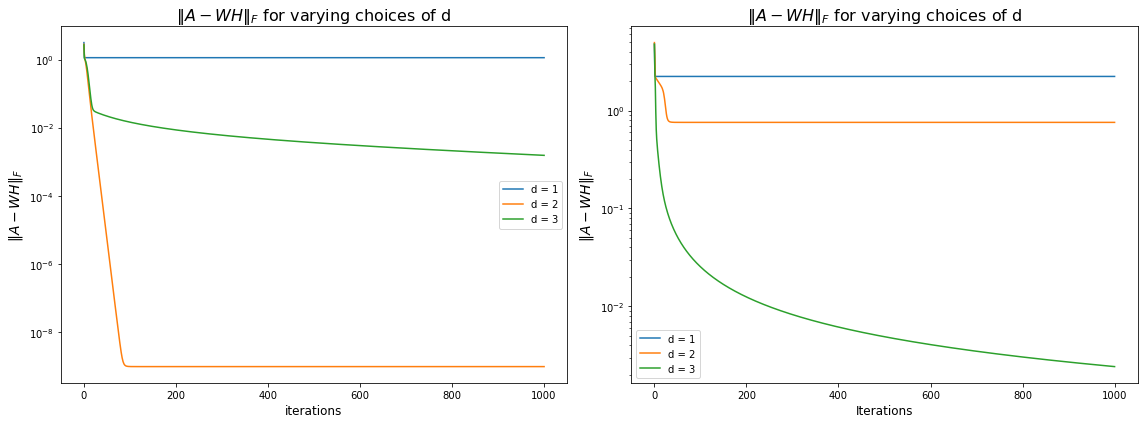

In [5]:
plt.rcParams["figure.figsize"] = (16,6)
fig, axs = plt.subplots(1,2)
for i in range(1,4):
    WA3, HA3, V_devA3 = NMF(A3,i,seed=1999)
    axs[0].semilogy(V_devA3,label = f"d = {i}")
    axs[0].legend()
axs[0].set_ylabel("$\Vert A - WH \Vert _F$",fontsize = 14)
axs[0].set_xlabel("iterations",fontsize = 12)
axs[0].set_title(f"$\Vert A - WH \Vert _F$ for varying choices of d",fontsize = 16)
for i in range(1,4):
    WA4, HA4, V_devA4 = NMF(A4,i,seed=1999)
    axs[1].semilogy(V_devA4,label = f"d = {i}")
    axs[1].legend()
axs[1].set_ylabel("$\Vert A - WH \Vert _F$",fontsize = 14)
axs[1].set_xlabel("Iterations", fontsize = 12)
axs[1].set_title(f"$\Vert A - WH \Vert _F$ for varying choices of d",fontsize = 16)
plt.tight_layout()
plt.show()

After running this code several times with different seeds we can see that when $d$ equals the rank of the initial matrix, the NMF algorithm seems to have less problems approximating the original matrix $A$. It is interesting to note that for $A_4$ we do not reach convergence even after 1000 iterations, but if we would have a sufficient number of iterations we would reach the minima. From the plot for $A_3$ you can also see that the algorithm converges to approximately $\delta$, even if you change its value. If not for this safe-division constant one could imagine that the algorithm would converge to zero (at least in theory). We will still keep the constant here for safetys sake, so the machine don't need to throw exceptions. For $d=1$ we never get anywhere no matter how many iterations. We can also see that our initial claim that $\lVert A-WH \rVert_F$ is a monotonically decreasing function, shows true for these plots. This is not very surprising however as this is a property of the multiplicative update rule, and the only reason this would not hold true could be explained with either floating point errors from the computer or the safe division constant $\delta$ we add in each iteration.

## Applying the NMF on CryptoPunks
We will now look at a dataset containing $10000$ different $24 \times 24$ pixel images of "faces". They are all unique, but some traits are reccuring like some headwear, beards, hairstyles, glasses and the likes, but every face has a different combination of traits. We will only load in $500$ images as the runtime may be a problem further down the line, and this can demonstrate everything we want to discuss anyway. They will be stored as a $24 \times 24 \times 4 \times 500$ array, where the number $4$ represents the rgb color and opacity values. Using NMF, we will experience that the columns of $W$ will represent common traits of the CryptoPunks and the rows of $H$ will be the weighting of the traits for the specific face.

In [7]:
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N: integer, number of images to load
    Output:
        faces: (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

# Check that the shape is correct
print(faces.shape)

(24, 24, 4, 500)


In [8]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None, title = " "):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    #Setting title for the plot
    st = fig.suptitle(title, fontsize = 'xx-large', color = 'blue')
    st.set_y(1)
    fig.subplots_adjust(top=1)
    # Tight layout so images will appear closer together
    plt.tight_layout()


    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

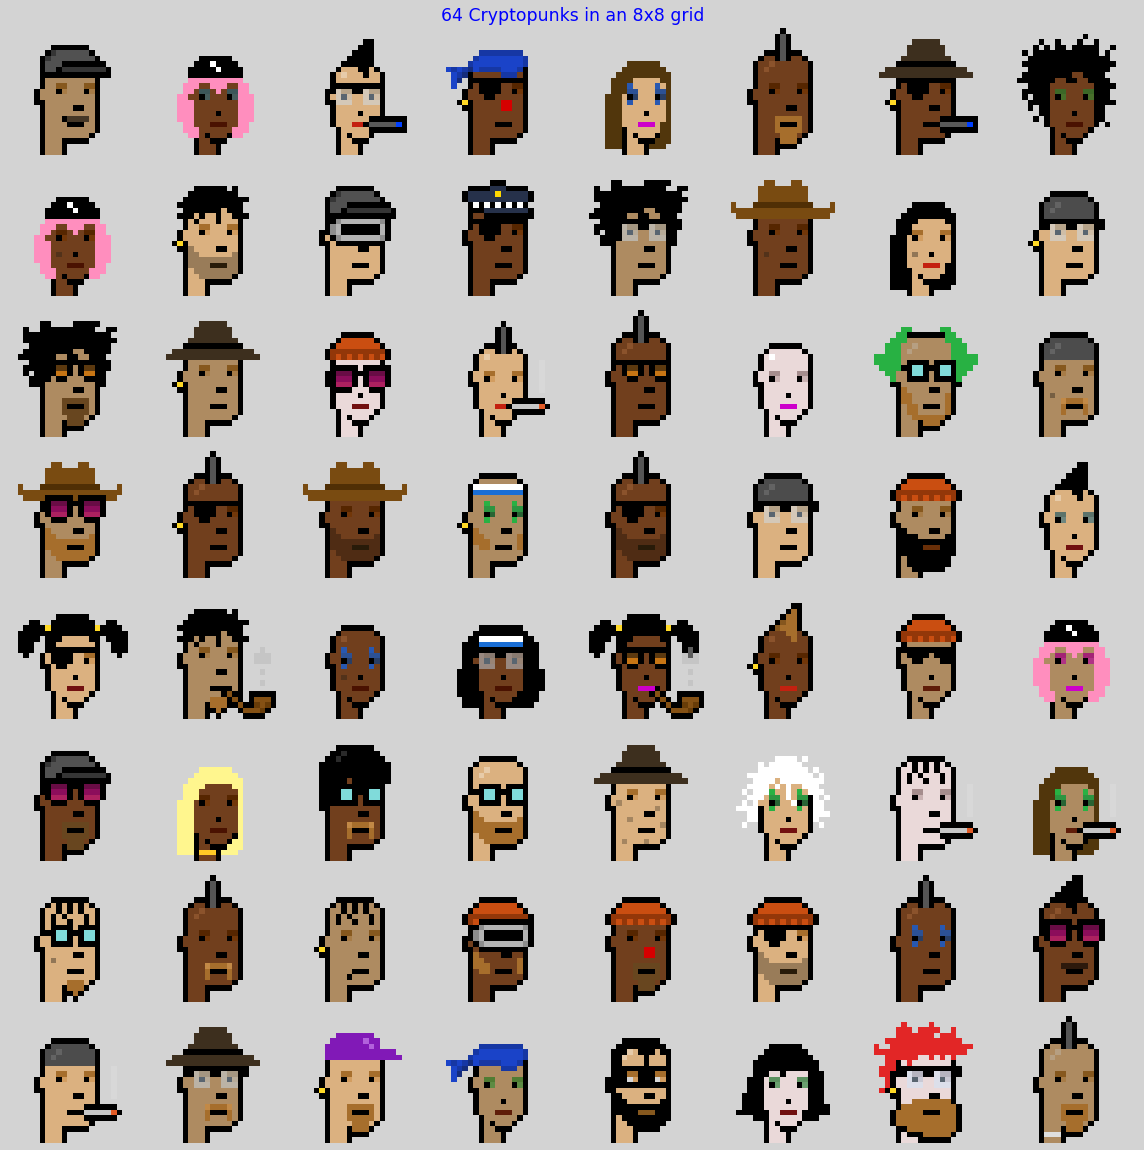

In [9]:
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
faces = np.where(faces > 1, 1, faces)
plotimgs(faces, 8,filename="punks.png",title="64 Cryptopunks in an 8x8 grid")

In [10]:
# Split the images into opacity and rgb channels
faces_opacity = faces[:,:,3,:]
faces_rgb = faces[:,:,:3,:]
shape = faces_rgb.shape

# Clever reshape "trick". This is the matrix we will apply the NMF to
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)

Rank of faces_reshaped: 385


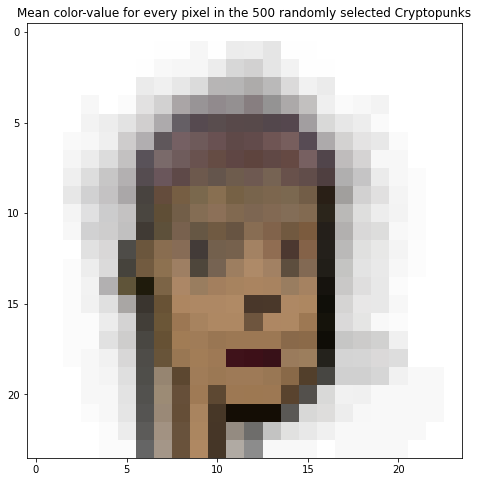

In [11]:
RGB_mean = np.mean(faces, axis=-1)
plt.rcParams["figure.figsize"] = (8,8)

plt.title("Mean color-value for every pixel in the 500 randomly selected Cryptopunks")
plt.imshow(RGB_mean)
print(f"Rank of faces_reshaped: {np.linalg.matrix_rank(faces_reshaped)}")

The above plot shows us the mean value for each pixel and color channel in our set of $500$ randomly selected CryptoPunks. This gives us the ability to investigate the common traits of the cryptopunks. The most prevelant traits will appear darker while traits that are uncommon will appear as pixels with differing shades of gray, where darker gray indicates that the pixel is often colored in. We observe that the placement of the mouth, nose, eyes, headshape and neck is almost identical for every CryptoPunk. Later we will use NMF to factorize each of these traits into the columns of $W$, so that we can decompose every CryptoPunk into a linear combination of traits that are common for every CryptoPunk. The padding of white pixels around each cryptopunk tells us that these pixels are never colored in, in other words these pixels have no opacity. The rank of our matrix containing the CryptoPunks tells us the dimension of the vector room spanned out by its columns. Practically it tells us how many CryptoPunks we need to represent an arbitrary CryptoPunk using a linear combination of linearly independent CryptoPunks. From theory section 2.3 in the project description and as we observed earlier in the application of NMF on $A_3$ and $A_4$. It is wise to choose a $d = rank(A)$, even though this does not give us a theoretical guarantee for perfect recreation, it gives us the recreation with the least amount of deviation from the matrix we want to factorize. In other words it gives us the best probability of minimizing $\lVert A - WH \rVert _F$. The rank of our matrix containing the CryptoPunks is 385. However the human eyes interpretation of what looks similar and $\lVert A - WH \rVert _F$ being small is not always the same. In the end, humans are not computers, and computers are not humans.  

#### The impact of the choice of d when applying the NMF

We will now study the importance of our choice of $d$ when applying the NMF to a matrix of CryptoPunks. Before we apply the NMF we split the RGB channels from the opacity channel. It is the RGB channels we want to apply the NMF to. This split is done above, in the code-block below the 8x8 grid of CryptoPunks. 

As aforementioned, the goal of our factorisation is to minimize the amount of data we have to store, without compromising our ability to recreate the original data. The recreation works by storing the different unique traits of CryptoPunks in the columns of $W$ and the weight for each CryptoPunk in the rows of $H$. When we recreate the data we simply use matrix multiplication, $WH$, this way each individual CryptoPunk is a linear combination of the traits stored in $W$, with the coefficients stored in $H$. 

In [12]:
W64, H64, V_dev64 = NMF(faces_reshaped,64)
W16, H16, V_dev16 = NMF(faces_reshaped,16)
W144, H144, V_dev144 = NMF(faces_reshaped,144)

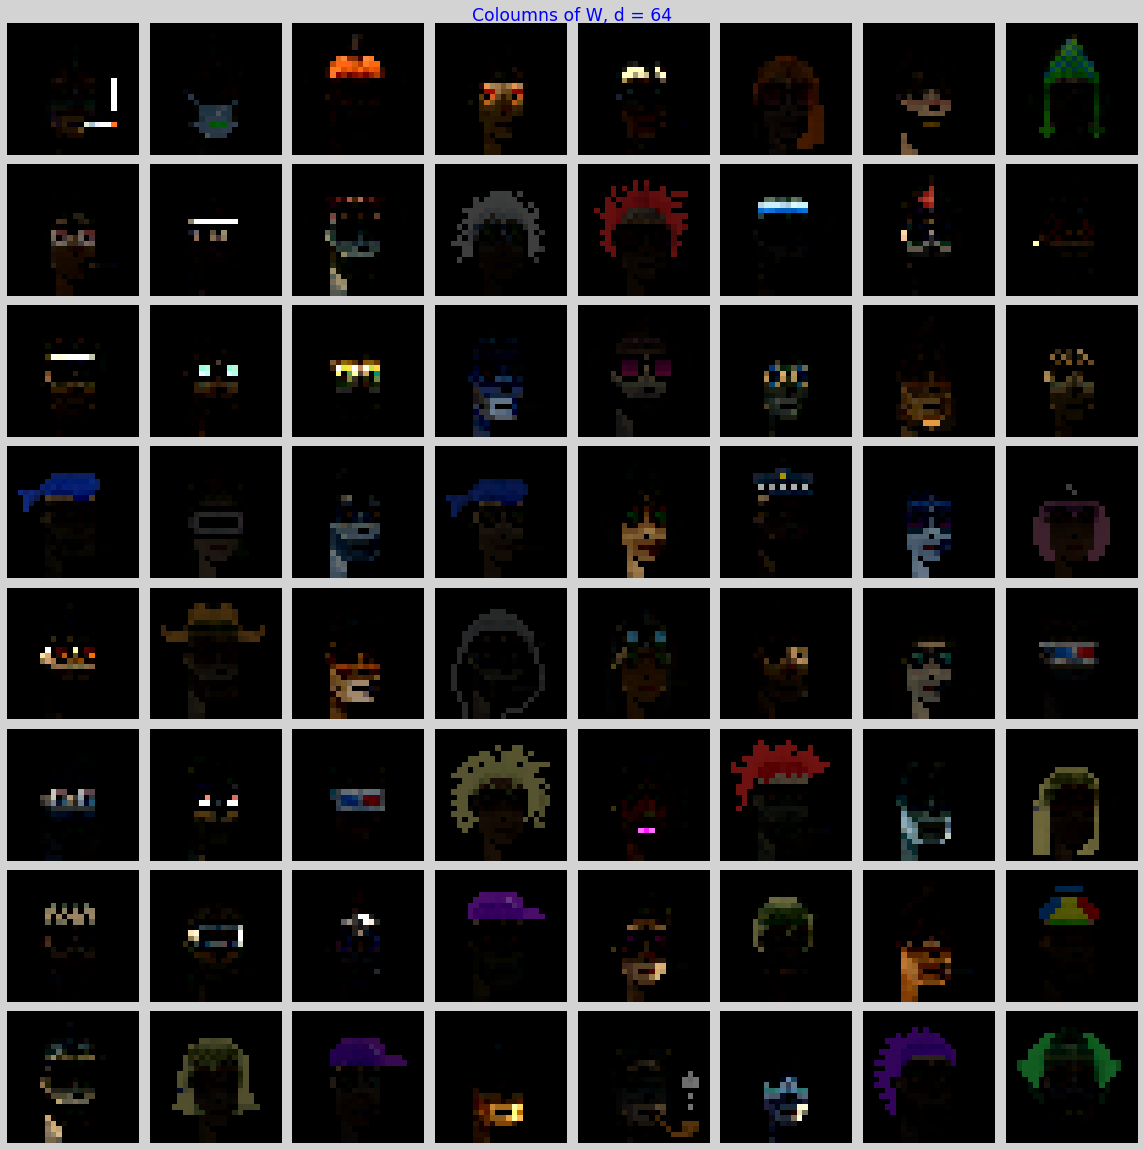

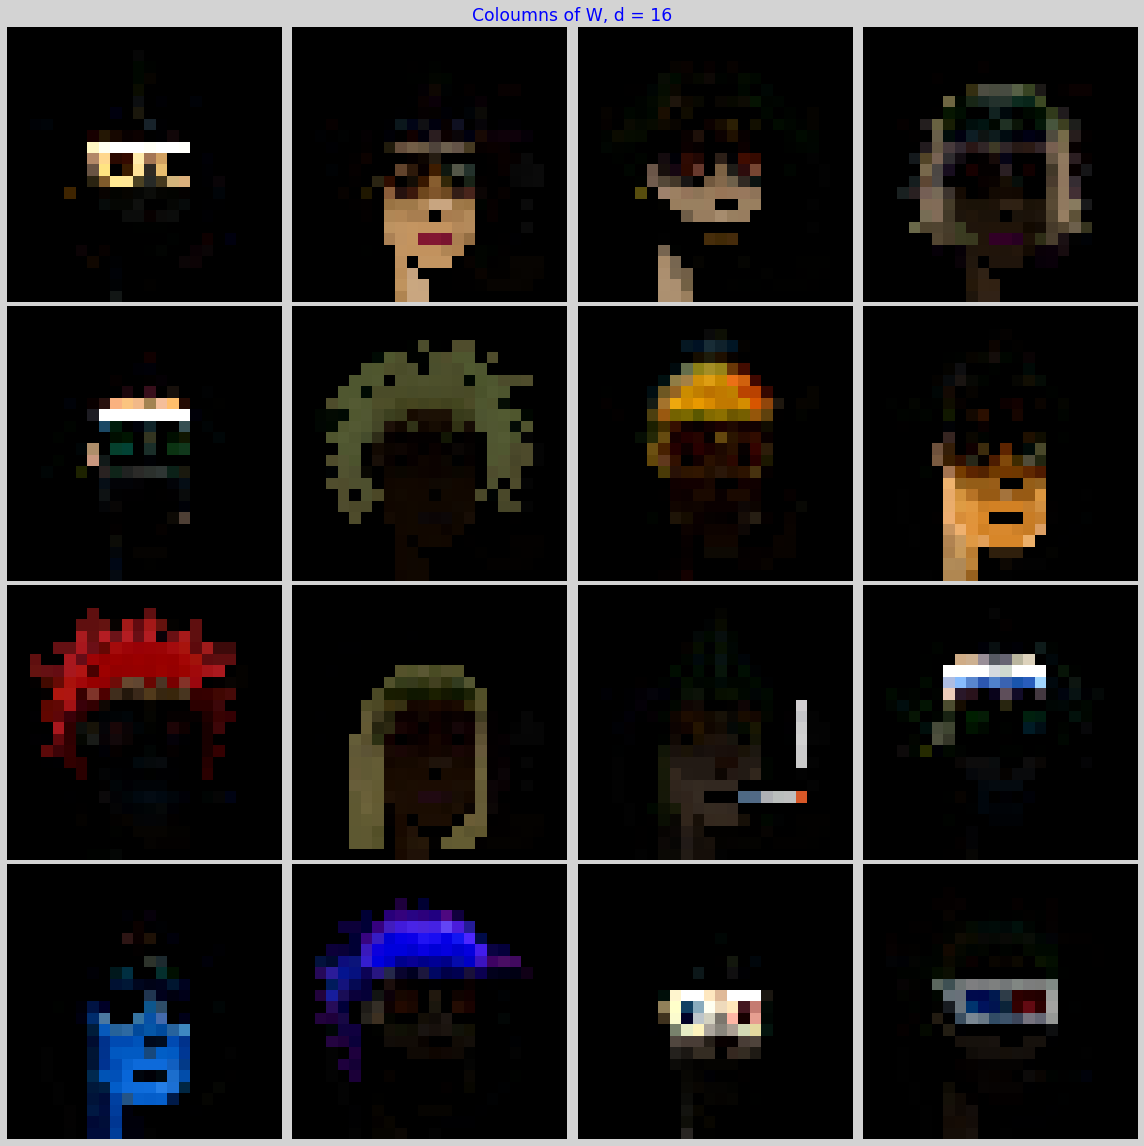

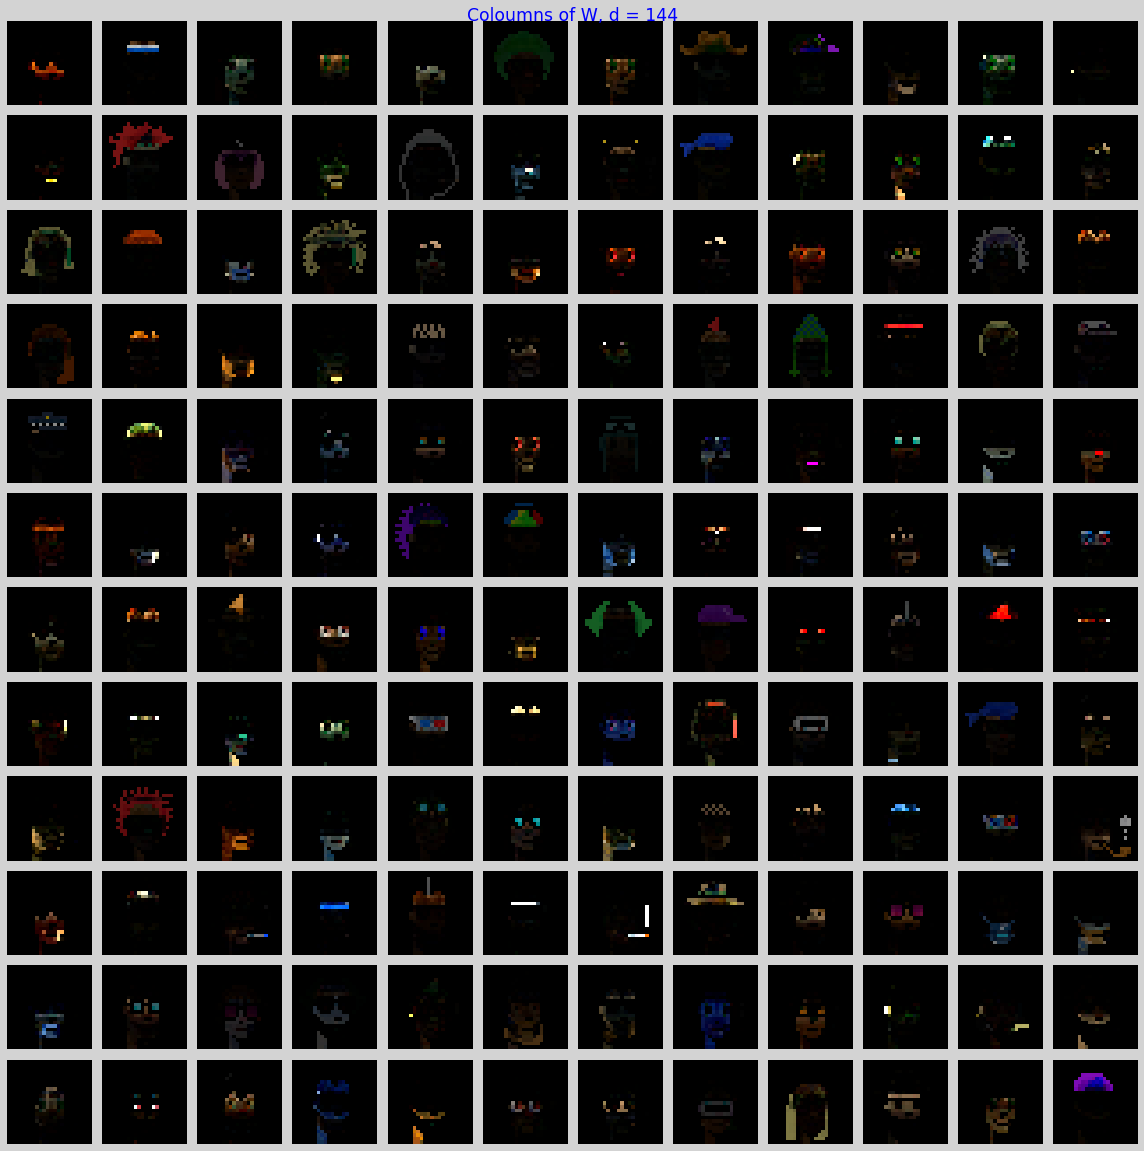

In [13]:
#Reshaping the columns of W
W_reshaped64 = np.where(W64 > 1,1,W64).reshape((24,24,3,64))
W_reshaped16 = np.where(W16 > 1,1,W16).reshape((24,24,3,16))
W_reshaped144 = np.where(W144 > 1,1,W144).reshape((24,24,3,144))

#Plotting the columns of W
plotimgs(W_reshaped64,8, title = "Columns of W, d = 64")
plotimgs(W_reshaped16,4, title = "Columns of W, d = 16")
plotimgs(W_reshaped144,12, title = "Columns of W, d = 144")

The columns of $W$ in the above plots are represented by each individual subplot. It is straightforward to see that when $d$ increases, the columns store more trait specific data, and therefore captures the important features of our dataset. This is easily observed by inspecting the matrix with $d=16$ and comparing it to $d=144$. With $d=16$ we can clearly see faces in the columns. While in the columns of $W_{144}$ the faces are more vague, and the unique traits and attributes, e.g. cigarette and 3D-glasses, are stored in individual columns with very little other data present.   

As we will see later the recreation of our matrices yields a better result using a $d$ that approaches the rank of our original matrix.  

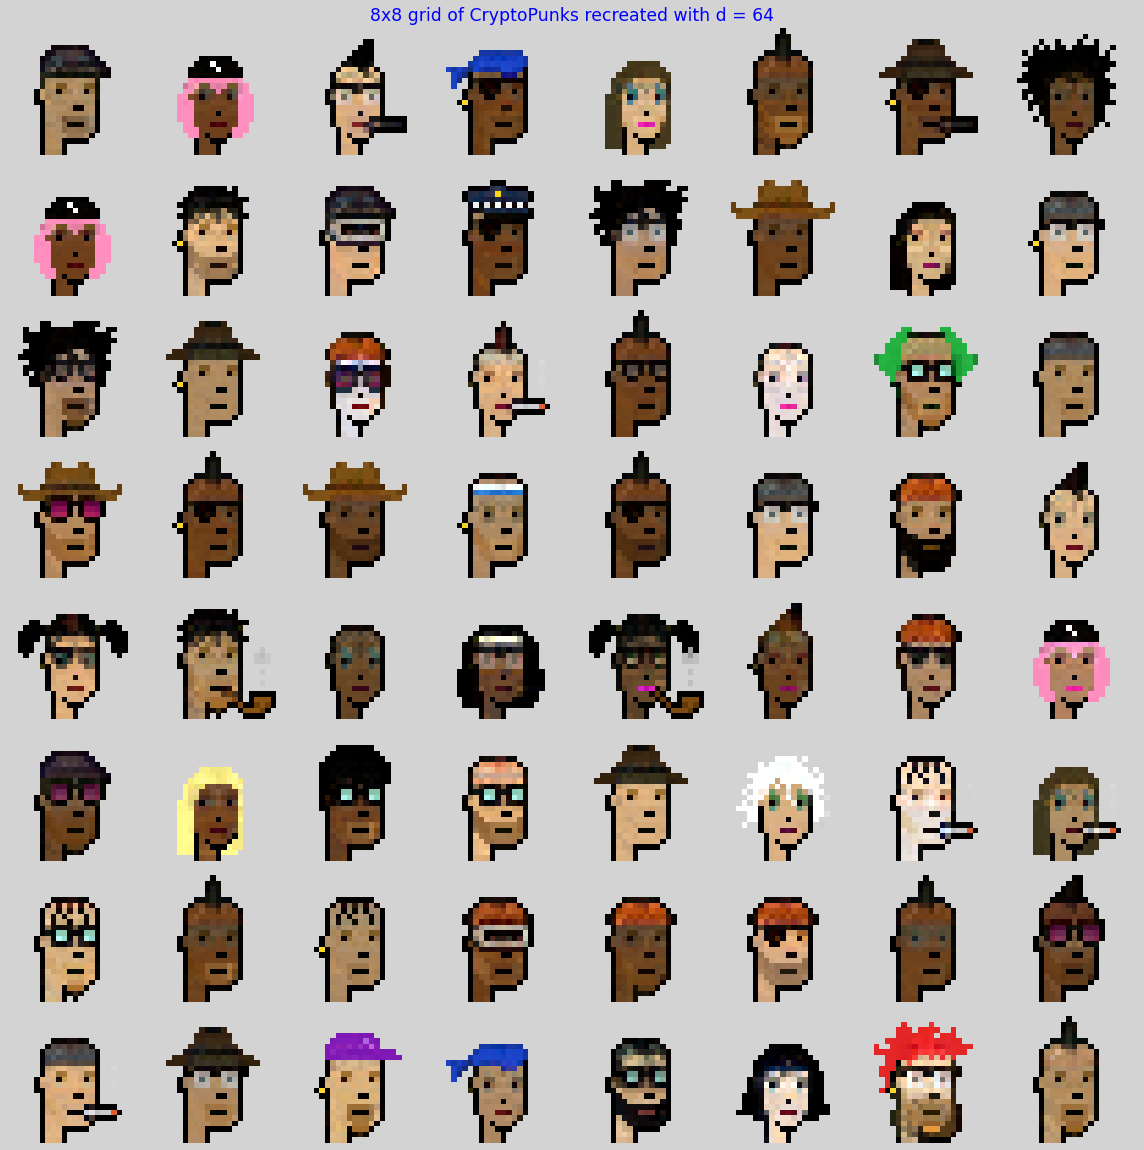

In [14]:
A_reconst = np.dot(W64,H64)
A_reconst = np.where(A_reconst > 1,1,A_reconst).reshape((24,24,3,500))
# For plotting noisy images we add the opacity
faces_with_opacity64 = np.zeros(faces.shape)
faces_with_opacity64[:,:,:3,:] = A_reconst.reshape(faces_rgb.shape)
faces_with_opacity64[:,:,3,:] = faces_opacity
plotimgs(faces_with_opacity64,8,title= "8x8 grid of CryptoPunks recreated with d = 64")

To aid the analysis of how well recreated the CryptoPunks are, we divide the original matrix by the reconstructed matrix. We have to add a safe division constant to avoid division by zero, but this does not affect the analysis because it is an order of magnitude $10^{-15}$. If the pixel is correctly recreated it is colored white, however a black pixel in the original matrix will still be black in our plot of $\frac{A}{WH}$. If the pixel is colored in, not counting black and white, it is an indication that the pixel is not succesfully recreated. The stronger the color, the worse the representation. 

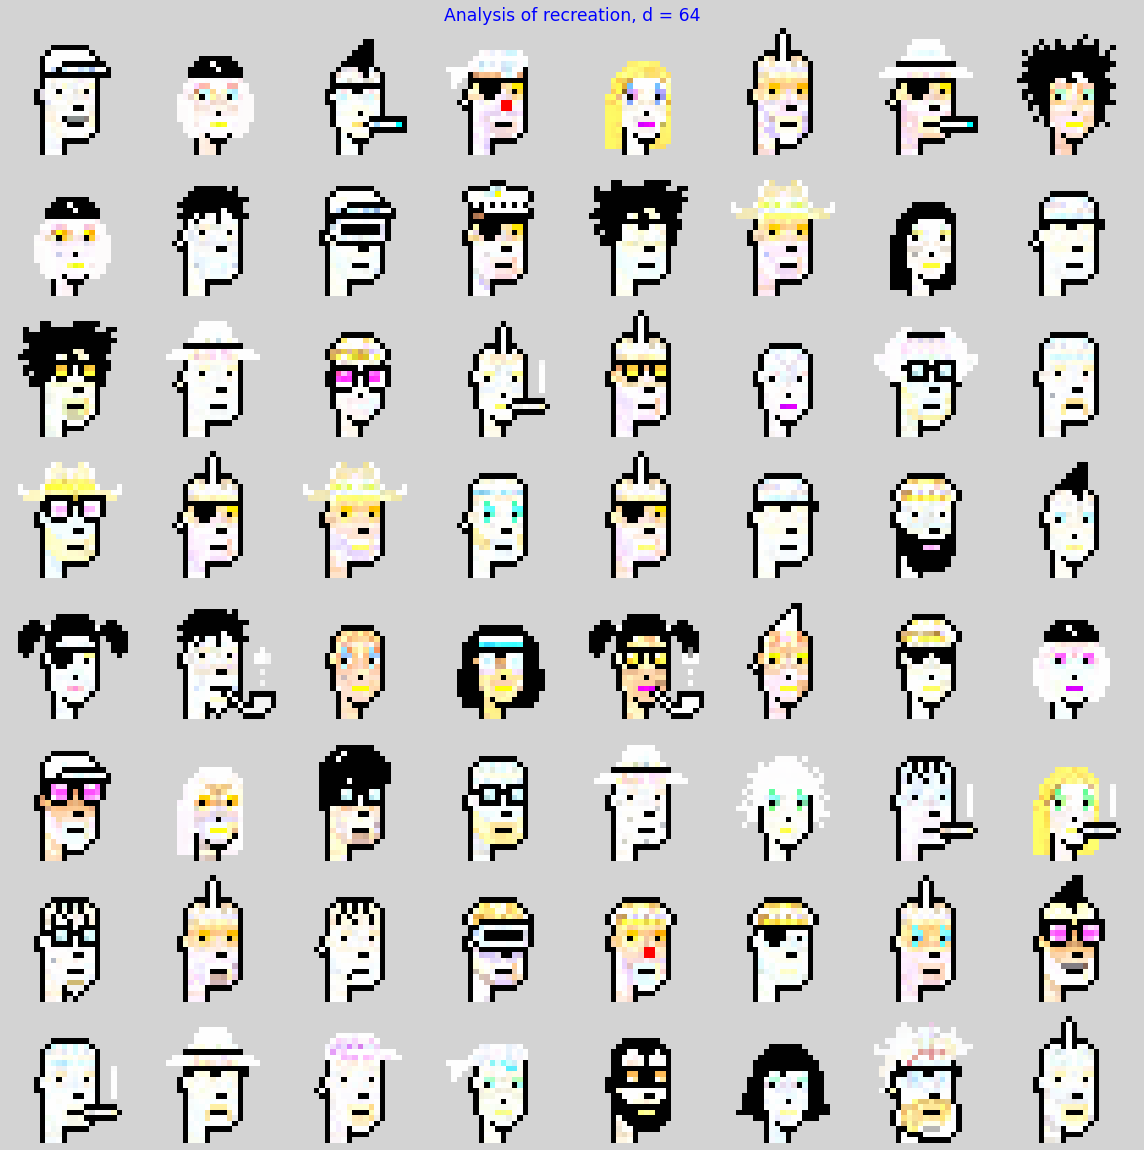

In [15]:
rec_rate = (faces/(faces_with_opacity64+1.e-15))
rec_rate = np.where(rec_rate > 1, 1, rec_rate)
plotimgs(rec_rate,8,title="Analysis of recreation, d = 64")

The pictures are overall well represented, to the human eye black pixels look perfectly recreated. This is because blacks RGB-value is $(0,0,0)$ and scaling a pixel to this value is easily done by setting its scaling coefficient to $0$. For other colors this is not as straightforward. When the machine groups information in the columns of $W$ it is hard to capture small nuances of color inside each individual trait and apparel, this is reflected by the fact that, caps, beards and glasses are not perfectly recreated. We also observe that the neighbouring pixels are also affected by this inaccuracy. Some of the CryptoPunks have non-black mouths, these are rarely perfectly recreated. If they are the surrounding beard or skin color is often poorly recreated. This is because our algorithm does not prioritise saving this trait, as it is not prevelant enough in our dataset.

Looking back at the reconstructed plot of CryptoPunks we can safely say that even though they are not perfectly reconstructed, we can easily pair the original CryptoPunk to the reconstructed one. In other words, the colors might be a little bit off, but we can clearly see which CryptoPunk the reconstruction is supposed to represent and also the distinguishing features of said CryptoPunk. To round up our analysis of recreation we will study how $\lVert A - WH \rVert _F$ changes for differing values of $d$.

In [16]:
#Simple printout of norms with differing d
print(f"Norm for d = 144: {V_dev144[-1]}")
print(f"Norm for d = 64: {V_dev64[-1]}")
print(f"Norm for d = 16: {V_dev16[-1]}")

Norm for d = 144: 17.887202702915133
Norm for d = 64: 39.96882896727086
Norm for d = 16: 83.75286965883339


As we expect, when $d$ increases $\lVert A - WH \rVert _F$ decreases. As aforementioned, and as we will see later larger $d$ does not necessarily imply a better result.  

In [17]:
W16,H16, V_dev16 = NMF(faces_reshaped,16)
W32,H32, V_dev32 = NMF(faces_reshaped,32)
W64,H64, V_dev64 = NMF(faces_reshaped,64)

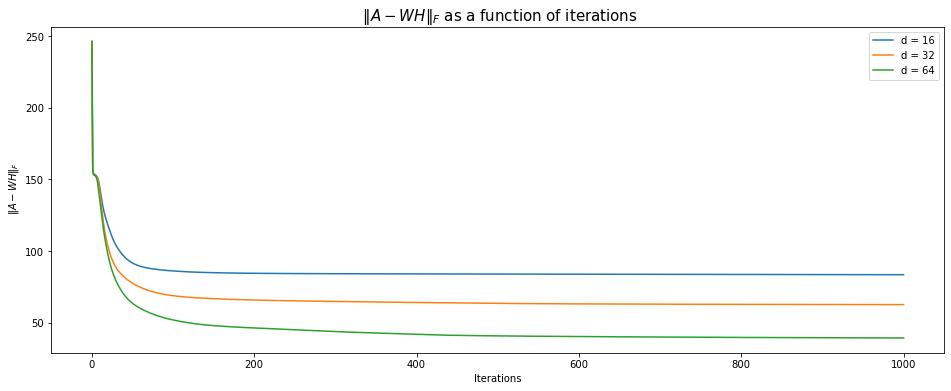

In [18]:
plt.rcParams["figure.figsize"] = (16,6)
plt.plot(V_dev16, label = f"d = {16}")
plt.plot(V_dev32, label = f"d = {32}")
plt.plot(V_dev64, label = f"d = {64}")
plt.xlabel("Iterations")
plt.ylabel(r" $\Vert A - WH \Vert _F$")
plt.title(label = r" $\Vert A - WH \Vert _F$ as a function of iterations",fontsize = 15)
plt.legend()
plt.show()

Our values for $d$ satisfies $\lVert A-W_{k+1}H_{k+1} \rVert_F \le \lVert A-W_{k}H_{k} \rVert_F $ because we can observe from the plot that $\lVert A-W_{k}H_{k} \rVert_F$ is a monotonically decreasing function. It is also straightforward to see that all three values have reached convergence after about 300 iterations.

In [19]:
W128, H128, V_dev128 = NMF(faces_reshaped,128)
W256, H256, V_dev256 = NMF(faces_reshaped,256)
W300, H300, V_dev350 = NMF(faces_reshaped,350)

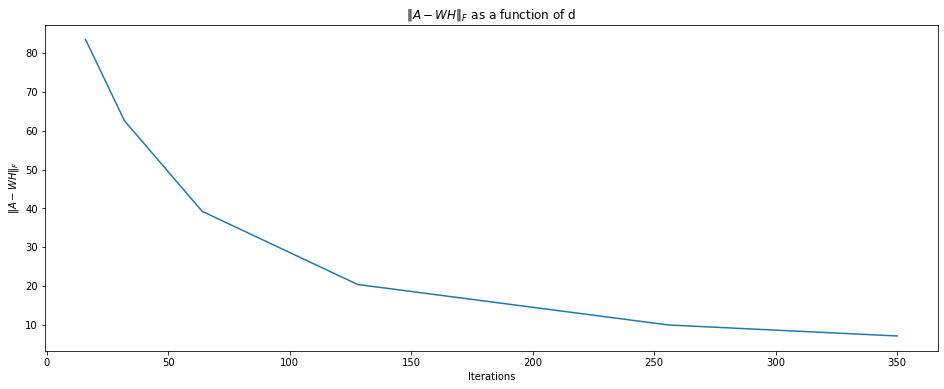

In [20]:
list_of_d2f = np.array([16,32,64,128,256,350])
list_of_norms = np.array([V_dev16[-1],V_dev32[-1],V_dev64[-1],V_dev128[-1],V_dev256[-1],V_dev350[-1]])
plt.title("$\Vert A - WH \Vert _F$ as a function of d")
plt.ylabel("$\Vert A - WH \Vert _F$")
plt.xlabel("Iterations")
plt.plot(list_of_d2f,list_of_norms, label = "$\Vert A - WH \Vert _F$")
plt.show()

Above $\lVert A - WH \rVert$ is plotted as a function of $d$. The graph indicates that as $d$ increases, so does the accuracy of our recreation. However, we also observe that as $d$ increases, the rate at which $\Vert A - WH \Vert _F$ decreases also decreases and as $d$ approaches $rank(A)$ the curve starts flattening out. Furthermore, the increase of accurate recreation related to the increase of $d$ is not the only thing to look at when measuring how succesfull our method is. It is absoluteley necessary to look at model complexity, storage and runtime. When $d$ increase, so does the runtime and the memory use of our algorithm. If we increase $d$ enough we will end up using more storage space than the original matrix, which makes the whole algorithm pointless for our use. As we discussed earlier $d = 64$ gives you a good recreation, we can calculate the relative storage space needed by comparing how many elements are in $W$ and $H$ to how many there are in $A$. This is easily done by the fraction $$\frac{elements(W) + elements(H)}{elements(A)}$$ Plugging in numbers for $d=64$ gives us: $$\frac{1728 \cdot 64 + 64 \cdot 500}{1728 \cdot 500} \approx 0.165 = 16.5 \%, $$ this means we reduce the amount of data by approximately $1-0.165 = 0.835  = 83.5 \%$ when using $d=64$. 

## Denoising of CryptoPunks using NMF
To study the applications of NMF in a more practical manner, we are now going to introduce noise to our CryptoPunks and study whether or not NMF is able to recreate the faces. Noise in this sense are just pixels with random colors placed sporadically on the faces and features. To add this to our matrix $A$ we add a matrix containing noise $\sigma E$ where $\sigma$ is a scalar which represents the intensity of the noise. $E$ has the same shape as $A$ and have its elements distributed using a standard normal distribution. We only add noise on $A$ where there is already existing pixel values, so no noise is added outside of the faces. Since NMF helps us store the prominent features of the CryptoPunks, a reconstruction matrix $WH$ will hopefully be able to remove some noise from the faces by merging the major features learned by the machine. This is worth investigating and once again a point of interest is $d$.

In [21]:
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

42.56843267678154


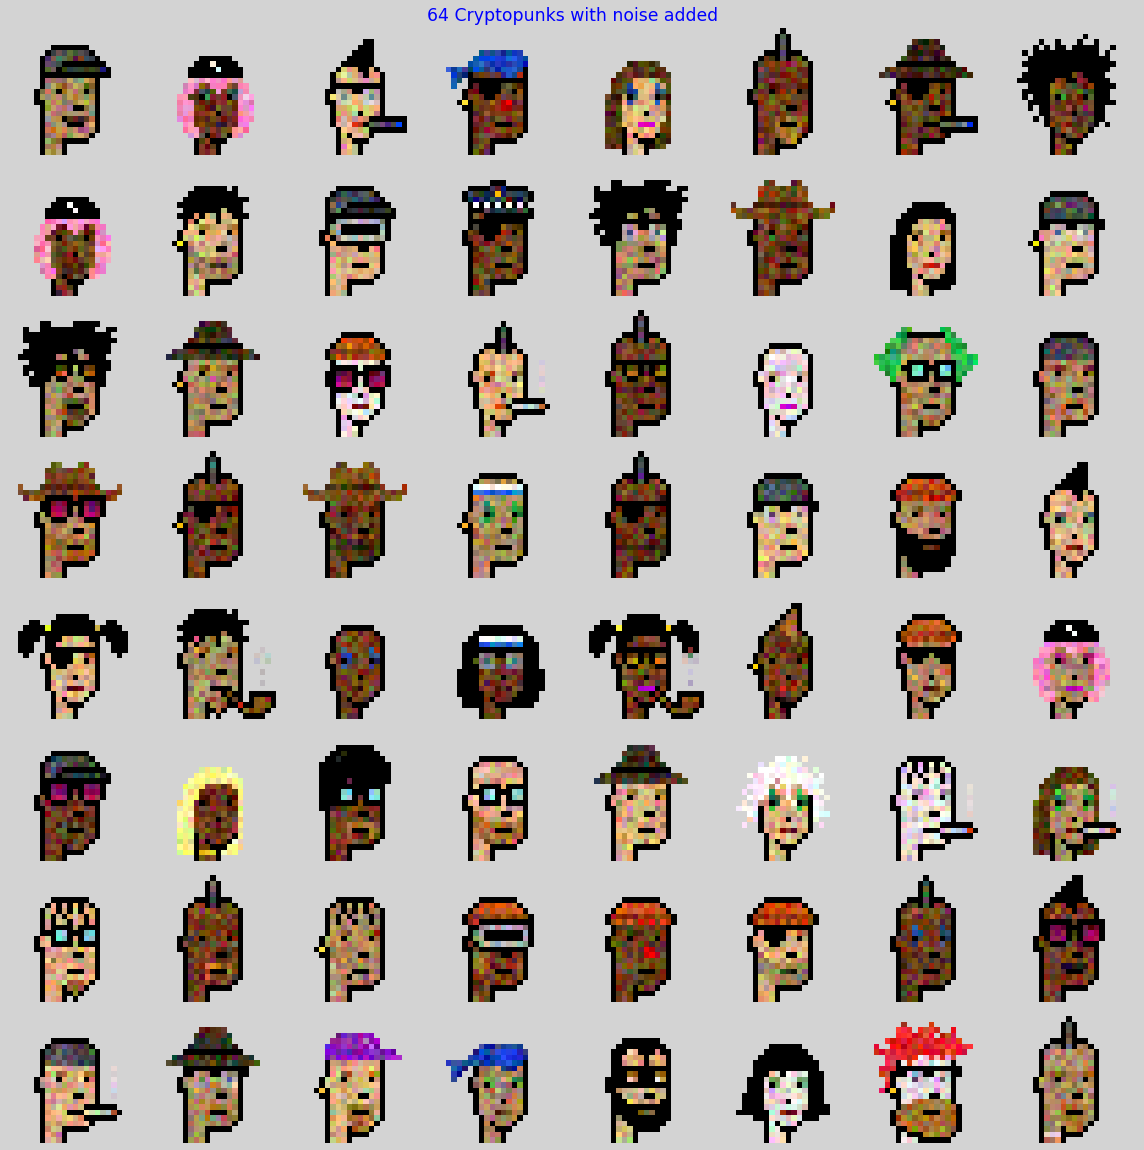

In [23]:
noisy_faces = add_noise(faces_reshaped)

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped)
print(noise_residual)

# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces.shape)
noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(faces_rgb.shape)
noisy_faces_with_opacity[:,:,3,:] = faces_opacity
plotimgs(noisy_faces_with_opacity,8,title= "64 Cryptopunks with noise added")

Here we can see a plot of 64 CryptoPunks with applied noise, it looks like they have had better days! The expression $ \lVert A_{noisy}-A \rVert_F$ shows how much the noisy matrix deviates from the same matrix without applied noise. This value is printed above and is $42.56843$

In [25]:
noisy_faces_reshaped = noisy_faces_with_opacity.reshape(np.prod(noisy_faces_with_opacity.shape)//N, N)
W_noise, H_noise, V_dev_noise = NMF(noisy_faces,64)

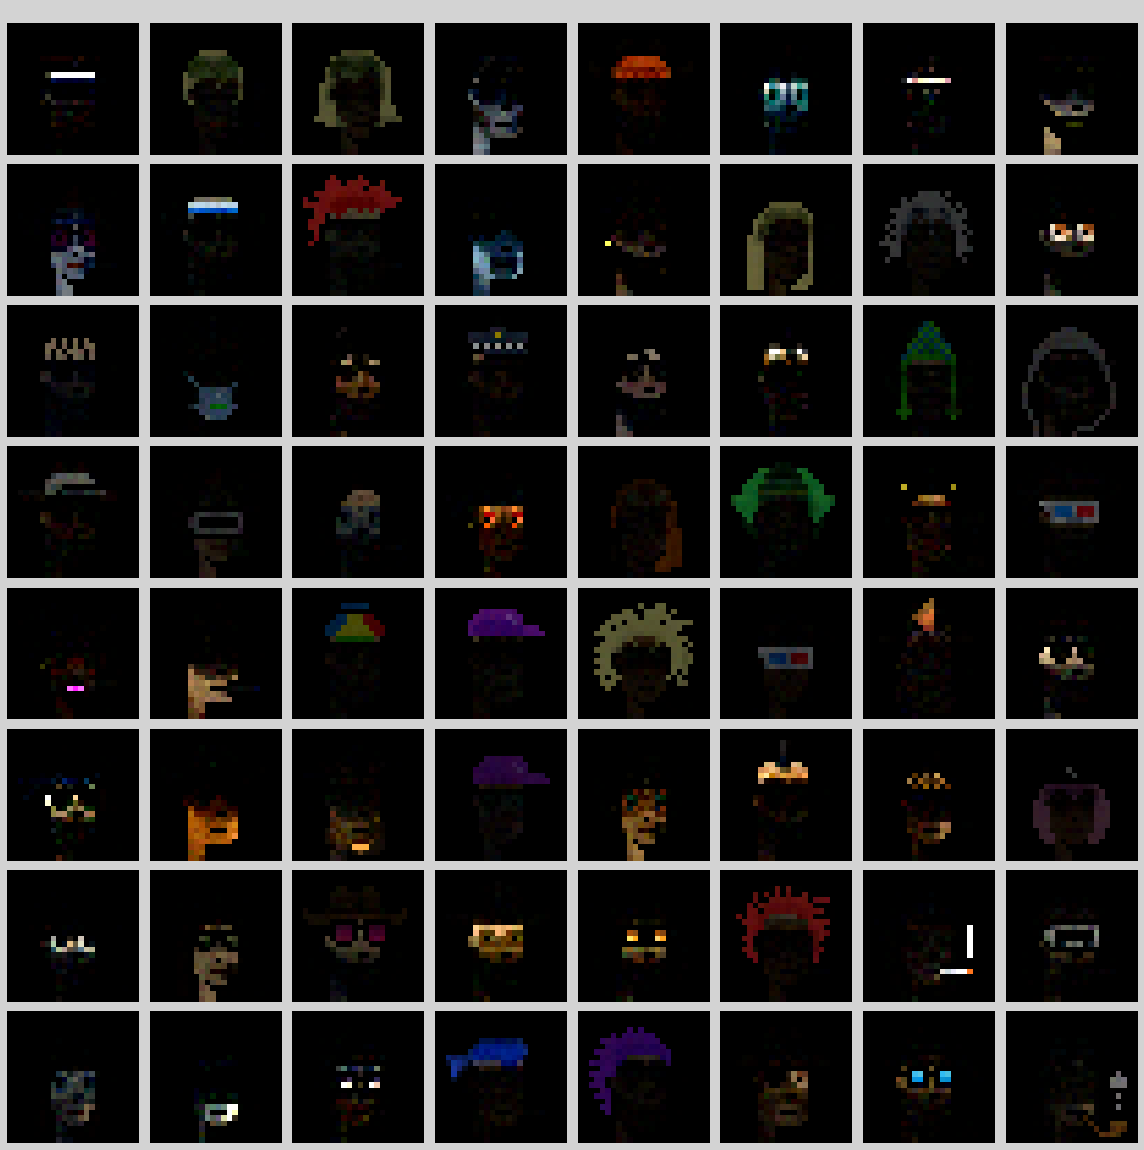

In [26]:
W_noise_reshaped = np.where(W_noise > 1,1,W_noise).reshape(24,24,3,64)
plotimgs(W_noise_reshaped,8)

This is a plot of the columns of $W$ with $d = 64$. Similar to the earlier plot of the columns of $W$, with no noise, we can see that some CryptoPunks traits have been separated, some more distinctively than others. Based on our previous analysis of the columns of $W$ this is just like we expected, and in fact we can see mostly the same features as before. In contrast we can also observe some noise in some of the different features shown in the plot. This also makes some of the stored features have more spread and some of the same traits have more pixels stored. All in all this is quite similar to what we observed earlier, with only slight differences from the matrix without any noise.

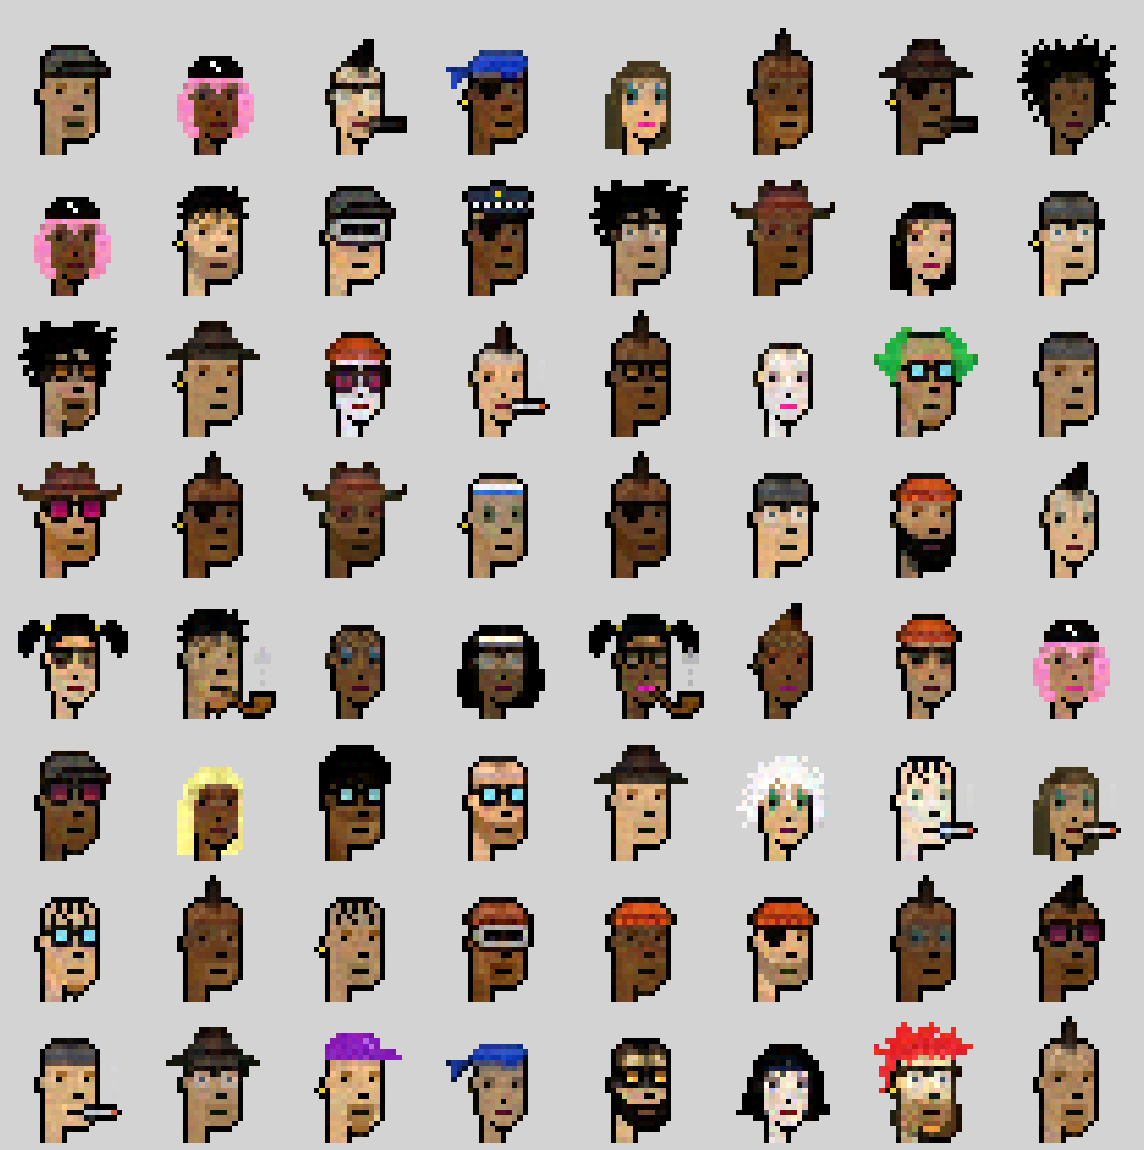

In [28]:
noise_reconstructed = np.dot(W_noise,H_noise)
noise_reconstructed = np.where(noise_reconstructed > 1, 1, noise_reconstructed).reshape(24,24,3,500)

# For plotting noisy images we add the opacity
recon_faces_with_opacity = np.zeros(faces.shape)
recon_faces_with_opacity[:,:,:3,:] = noise_reconstructed.reshape(faces_rgb.shape)
recon_faces_with_opacity[:,:,3,:] = faces_opacity
plotimgs(recon_faces_with_opacity,8)

We have now made a reaconstructed matrix $WH$ with the noisy CryptoPunks. This is still for $d=64$ and the results look quite promising. A lot of the noise is gone or have severely faded. It is not a perfect representation of the CryptoPunks as we can clearly see some unnatural color values, though most values are in the right color neighbourhood. We still experience some faults in representing features just like without the noise due to our value $d$. Although we learnt earlier that a larger $d$ would give us a better reconstruction, we might not experience the same now due to the noise, because the training data might be underfitting or overfitting the model. To find the optimal $d$ we will now test the NMF for a variety of values.

To test the extremities and get clearer results we set $\sigma = 0.2$. This will help us underline some key points.

80.04419403705661


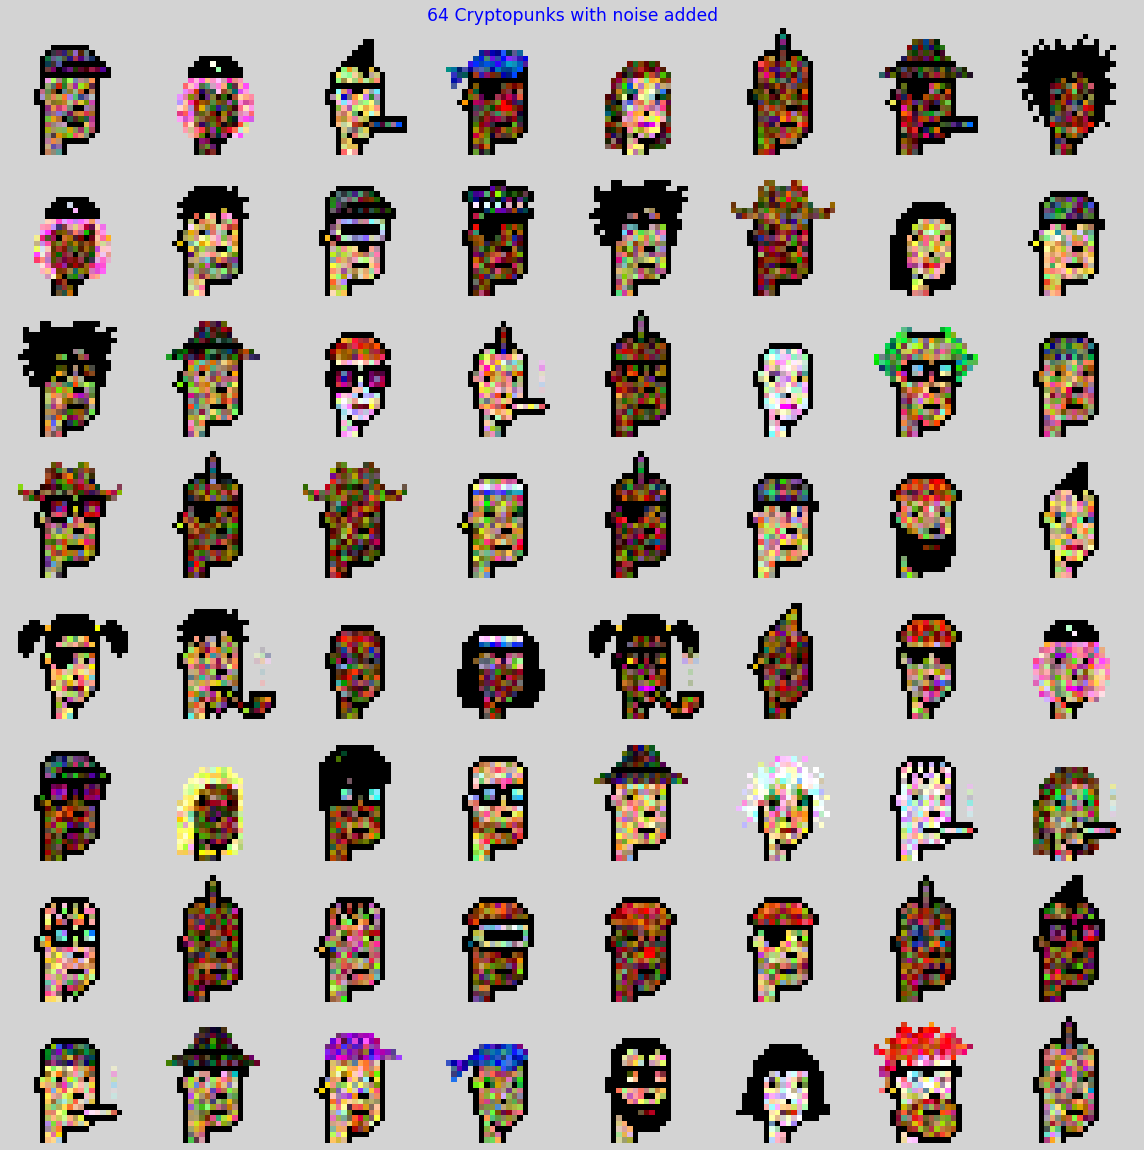

In [29]:
noisy_faces = add_noise(faces_reshaped,sigma=0.2)

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped)
print(noise_residual)

# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces.shape)
noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(faces_rgb.shape)
noisy_faces_with_opacity[:,:,3,:] = faces_opacity
plotimgs(noisy_faces_with_opacity,8,title= "64 Cryptopunks with noise added")

In [36]:
noisy_faces2 = add_noise(faces_reshaped, sigma=0.2)
W16n,H16n, V_dev16n = NMF(noisy_faces2,16)
W32n,H32n, V_dev32n = NMF(noisy_faces2,32)
W64n,H64n, V_dev64n = NMF(noisy_faces2,64)
W128n,H128n, V_dev128n = NMF(noisy_faces2,128)
W256n,H256n, V_dev256n = NMF(noisy_faces2,256)

In [31]:
noisy_faces_w_opac = np.zeros(faces.shape)
noisy_faces_w_opac[:,:,:3,:] = noisy_faces2.reshape(faces_rgb.shape)
noisy_faces_w_opac[:,:,3,:] = faces_opacity

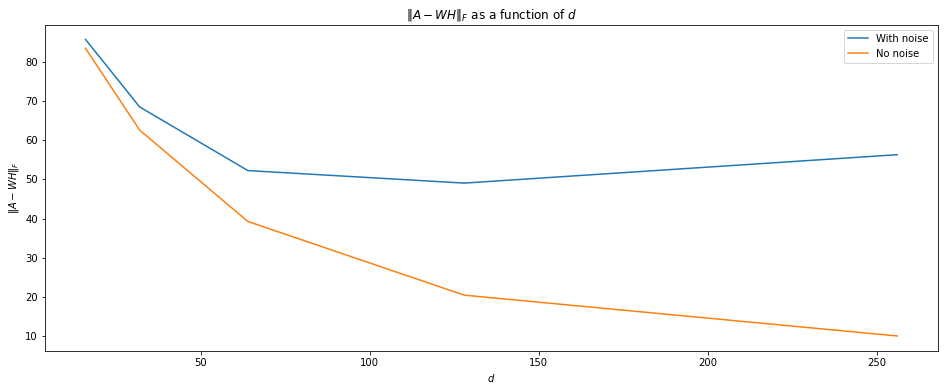

In [46]:
list_of_norms_noisy = np.zeros(5)
noise_reconstructed_w_opac_array = []
WH_array = np.array([np.dot(W16n,H16n),np.dot(W32n,H32n),np.dot(W64n,H64n),np.dot(W128n,H128n),np.dot(W256n,H256n)])
for i in range(5):
    noise_reconstructed_w_opac = np.zeros(faces.shape)
    noise_reconstructed_w_opac[:,:,:3,:] = WH_array[i].reshape(faces_rgb.shape)
    noise_reconstructed_w_opac[:,:,3,:] = faces_opacity
    list_of_norms_noisy[i] = np.linalg.norm(faces - noise_reconstructed_w_opac)
    noise_reconstructed_w_opac_array.append(noise_reconstructed_w_opac)
plt.plot(list_of_d2f[0:5], list_of_norms_noisy, label="With noise")
plt.plot(list_of_d2f[0:5],list_of_norms[0:5], label="No noise")
plt.legend()
plt.title("$\Vert A-WH \Vert_F$ as a function of $d$")
plt.ylabel("$\Vert A - WH \Vert _F$")
plt.xlabel("$d$")
plt.show()

We have now ran the NMF algorithm with values for $d$ as $16,32,64,128,256$ respectively just like last time. With $\lVert A-WH\rVert_F$ on the $y$-axis, where $A$ is the original matrix of faces without noise. To illustrate the difference we reuse our plot of the reconstruction matrices with the same values for $d$. The first thing we notice is that the noisy faces does not get better at reconstructing $A$ with an increasing $d$ and there will be a certain point that will be the optimal $d$ for reconstructing the CryptoPunks. This is quite interesting and one of the main studies of machine learning, because on one side we need to have enough features to recreate the faces, but on the other side we also do not want to train the machine to focus on the noise. If we have a small $d$ we will underfit the model with limiting the amount of features stored in columns of $W$ so it is hard to recognise the faces and many of them will be generic looking. On the other hand increasing $d$ too much, we will get an overfitted model, which means that we save a lot of specific features and the machine will look at noise as part of the trait. Our goal here is to try and recreate the CryptoPunks as they were before adding noise, so this is definitely something we want to avoid. The best value of $d$ would in theory be the one with the lowest $\lVert A-WH\rVert_F$ and for our values this would be $d=128$, however $d=64$ is not very far from the lowest. We have multiple arguments here to choose $d=64$ over $128$:
- The model complexity increases with the value of $d$, and rule number one in machine learning is to not increase model complexity when not neccessary.
- Our initial point was to store the least amount of data, and the number of data in a $W$ and $H$ with $d=64$ is significantly smaller than for $d=128$.
- As explained earlier training the data with an increasing $d$ leads to more noise being added to the reconstrucion, which is quickly apparent, even for these "good" values of $d$ 

In [59]:
# Reshaping the noisy matrices
for i in range(5):
    noise_reconstructed_w_opac_array[i][:,:,:,:] = np.where(noise_reconstructed_w_opac_array[i][:,:,:,:] > 1, 1, noise_reconstructed_w_opac_array[i][:,:,:,:])

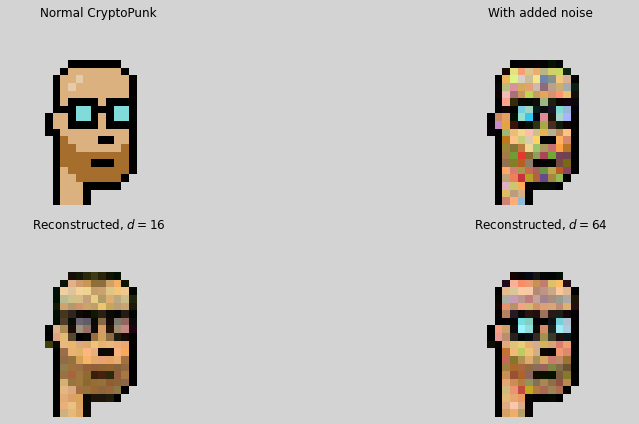

In [60]:
fig, axs = plt.subplots(2,2)
plt.gcf().set_facecolor("lightgray")

axs[0,0].imshow(faces[:,:,:,43]) # Normal dude
axs[0,0].axis('off')
axs[0,0].set_title("Normal CryptoPunk")




axs[0,1].imshow(noise_reconstructed_w_opac[:,:,:,43]) # After added noise
axs[0,1].axis('off')
axs[0,1].set_title("With added noise")



axs[1,0].imshow(noise_reconstructed_w_opac_array[0][:,:,:,43]) # Underfitted
axs[1,0].axis('off')
axs[1,0].set_title("Reconstructed, $d = 16$")


axs[1,1].imshow(noise_reconstructed_w_opac_array[2][:,:,:,43]) # Best reconstruction
axs[1,1].axis('off')
axs[1,1].set_title("Reconstructed, $d = 64$")


plt.tight_layout()
plt.show()

Here is the same CryptoPunk shown with added noise and reconstructed with $d = 16$ and $d = 64$. The noise is quite strong, and it fades away for the small value of $d$, however for $d=16$ the algorithm does not represent all the feature very accurately as a result of underfitting. An example of this is that his eyewear is missing the glass. With $d=64$ we get a lot more noise represented in the reconstruction, but the all the right features are present. At least the reconstruction has a lot less noise than the original with applied noise, and it is generally more recognizable.

All in all the NMF algorithm seems to do a reasonable job at removeing noise from the CryptoPunks and reconstructing them in general. It is quite impressive that $WH$ does such a good job of representing $A$, even though the amount of data is significantly reduced. One can understand the many applications of this machine learning method, when it defines, utilize and categorizes different traits all on its own. It is not however a method without flaws, first of all it needs a big dataset to work properly. The items in the dataset also need to be quite similar which can be difficult to obtain. Secondly the method can only be applied on a $n \times m$ matrix which is not always as trivial to reshape like it is here. Finally we have the problem of finding the optimal $d$, this is a recurring problem in the field of machine learning and statistical learning. Underfitting data might yield uninteresting results, while overfitting the data might ruin your ability to predict future data. 

In the study of denoising images, it is useful that this is an unsupervised learning method, because it can be hard to pinpoint the noise as it is usually random. A supervised method might be more accurate, and probably is, but NMF is stupidly easy to implement which is also a big plus. A point to note is that the NMF algorithm as it is implemented here is quite slow considering we have a runtime of several minutes with only $24 \times 24$ pixel images, which makes the practical applications somewhat limited. Humanity is on the verge of greatness in the field of machine learning, and it is only a question of time before artificial life will arise. Non-Negative Matrix Factorization might be outperformed in a few years or it might live on and have many more applications than today. It is obviously powerful and certainly has a lot of potential, but only time will tell.